In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time

0.0015697479248046875
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.08 0.08 0.   0.   0.   0.  ]
 [0.   0.   0.   0.52 1.   1.   0.4  0.   0.   0.  ]
 [0.   0.   0.12 1.   1.   1.   0.96 0.   0.   0.  ]
 [0.   0.   0.12 1.   1.   1.   1.   0.04 0.   0.  ]
 [0.   0.   0.   0.56 1.   1.   0.44 0.   0.   0.  ]
 [0.   0.   0.   0.   0.12 0.08 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


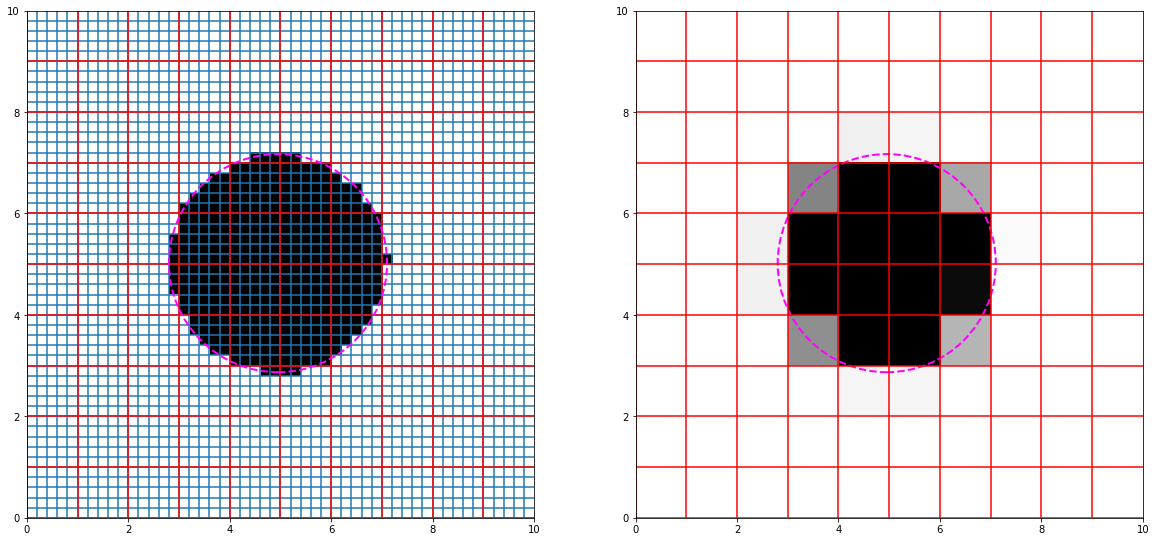

In [126]:
data = np.ones((5,10,10))

data_shape = data.shape
size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]

start = time.time()
Y,X = np.ogrid[0:size_y,0:size_x]

core_diameter_pixels = 4.3
core_radius_pixels = core_diameter_pixels/2
#np.random.seed(0)
core_x_pixels = np.random.uniform(low=4.3,high=5.7)
core_y_pixels = np.random.uniform(low=4.3,high=5.7)

weight_map = np.zeros((size_y,size_x)).astype(int)

weight_map[(np.abs(X+0.5-core_x_pixels)<(core_radius_pixels+0.5)) * (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1

rows,cols = np.argwhere(weight_map).T
row_min,row_max = np.min(rows),np.max(rows)+1
col_min,col_max = np.min(cols),np.max(cols)+1


rfactor = 5

# # the refined grid is defined to have a minimum of 100 pixels
# # accross the diameter of the fiber
# rfactor = int(100/core_diameter_pixels)
# # if the diameter exceeds 100 pixels already, 
# # use the original regular grid
# if rfactor<1:
#     rfactor = 1
rsize_x,rsize_y = (col_max-col_min)*rfactor,(row_max-row_min)*rfactor
Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
maskr = np.zeros((rsize_y,rsize_x))


maskr[np.sqrt((Xr+col_min*rfactor+0.5 - core_x_pixels*rfactor)**2 +
              (Yr+row_min*rfactor+0.5 - core_y_pixels*rfactor)**2) < core_radius_pixels*rfactor ]=1

weight_mapr = np.zeros((size_y*rfactor,size_x*rfactor))
weight_mapr[row_min*rfactor:row_max*rfactor,col_min*rfactor:col_max*rfactor] = maskr

patch = maskr.reshape(row_max-row_min,rfactor,col_max-col_min,rfactor).sum(axis=(1,3)).astype(float)/rfactor**2

weight_map = weight_map.astype(float)
weight_map[row_min:row_max,col_min:col_max]=patch

core_array = np.sum(data * weight_map.reshape(1,size_y,size_x),axis=(1,2)),np.pi*core_radius_pixels**2

print(time.time()-start)


fig,axarr = plt.subplots(1,2,figsize=(20,10))

ax = axarr.flat[0]
ax.imshow(weight_mapr,cmap='Greys',origin='lower',extent=(0,size_x,0,size_y))

core = Circle(xy=(core_x_pixels,core_y_pixels),radius=core_diameter_pixels/2,
              transform=ax.transData,edgecolor='magenta',facecolor='None',linestyle='dashed',linewidth=2,zorder=9)

for i in range(size_x*rfactor):
    ax.axvline(i/rfactor)
    ax.axhline(i/rfactor)
    
for i in range(size_x):
    ax.axvline(i,color='red')
    ax.axhline(i,color='red')
    
ax.add_artist(core)

ax = axarr.flat[1]
ax.imshow(weight_map,cmap='Greys',origin='lower',extent=(0,size_x,0,size_y),vmin=0,vmax=1)

for i in range(size_x):
    ax.axvline(i,color='red')
    ax.axhline(i,color='red')

core = Circle(xy=(core_x_pixels,core_y_pixels),radius=core_diameter_pixels/2,
              transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')

ax.add_artist(core)
print(weight_map)

In [60]:
data = np.ones((1000,512,512))
core_diameter_pixels = 4.3
core_x_pixels = np.random.uniform(low=4.3,high=5.7)
core_y_pixels = np.random.uniform(low=4.3,high=5.7)

def Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels):
    '''`data` must be in format (Nels,spatial_yels,spatial_xels).Nels denotes 
    the number of wavelength/velocity elements. Consequently, data[0] should 
    return a slice of the cube with dimensions (spatial_yels, spatial_xels).'''
    
    data_shape = data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    
    core_radius_pixels = core_diameter_pixels/2
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    # initialize weight map
    weight_map = np.zeros((size_y,size_x)).astype(int)
    # select rectangular region around fiber
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    rows,cols = np.argwhere(weight_map).T
    row_min,row_max = np.min(rows),np.max(rows)+1
    col_min,col_max = np.min(cols),np.max(cols)+1
    
    
    # the refined grid is defined to have a minimum of 100 pixels
    # accross the diameter of the fiber
    rfactor = int(100/core_diameter_pixels)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    if rfactor<1:
        rfactor = 1

    rsize_x,rsize_y = (col_max-col_min)*rfactor,(row_max-row_min)*rfactor
    Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
    maskr = np.zeros((rsize_y,rsize_x))


    maskr[np.sqrt((Xr+col_min*rfactor+0.5 - core_x_pixels*rfactor)**2 +
                  (Yr+row_min*rfactor+0.5 - core_y_pixels*rfactor)**2) < core_radius_pixels*rfactor ]=1

    weight_mapr = np.zeros((size_y*rfactor,size_x*rfactor))
    weight_mapr[row_min*rfactor:row_max*rfactor,col_min*rfactor:col_max*rfactor] = maskr

    patch = maskr.reshape(row_max-row_min,rfactor,col_max-col_min,rfactor).sum(axis=(1,3)).astype(float)/rfactor**2

    weight_map = weight_map.astype(float)
    weight_map[row_min:row_max,col_min:col_max]=patch
    
    return(np.sum(data*weight_map.reshape(1,size_y,size_x),axis=(1,2)))


start = time.time()
core_array = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels)

print(time.time()-start)
size_x = data.shape[2]
size_y = data.shape[1]






11.403281927108765


In [85]:
x = np.array(1)
y = 1.
x = np.array([y,]).astype(float)

print(type(x)==np.ndarray)
print(x.shape[0])
print(x)

core_x_pixels = 3
if type(core_x_pixels) in [float,int]:
    core_x_pixels = np.array([core_x_pixels,]).astype(float)

print(core_x_pixels)

print(np.array([1,2,3,4]).shape)

print(type(x) in [list,np.ndarray])

True
1
[1.]
[3.]
(4,)
True


0.04069113731384277
10 10


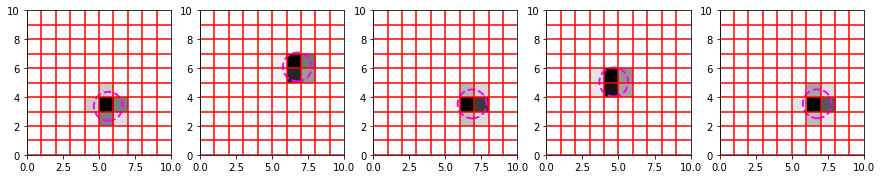

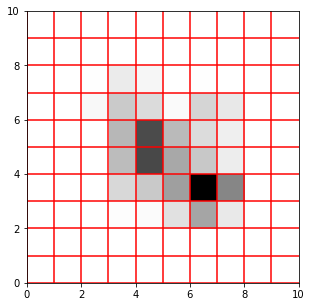

In [10]:
data = np.ones((1024,10,10))
n_fibers = 10
core_diameter_pixels = 2 # np.random.uniform(low=2,high=6,size=n_fibers)
core_x_pixels = np.random.uniform(low=3,high=7,size=n_fibers)
core_y_pixels = np.random.uniform(low=3,high=7,size=n_fibers)
output_grid_dims = (10,10)

def Fiber_Observe(cube_data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=False):
    '''
    Produces an ndarray of losvds/spectra for each fiber applied to the data. 
    
    `cube_data` [numpy.ndarray] must be in format (`Nels`,`spatial_yels`,
    `spatial_xels`). `Nels` denotes the number of wavelength/velocity elements.
    `spatial_xels` and `spatial_yels` denote the spatial dimensions of the data.
    Consequently, `cube_data[0]` should return a slice of the cube with dimensions: 
    
    `cube_data[0].shape`: (`spatial_yels`,`spatial_xels`). 
    
    `core_x[y]_pixels`: [float,int,list,numpy.ndarray] 
        The `x`[`y`] (or column[row]) positions of the fiber core centroids. Can 
        be a single value (e.g. float) or an array/list of values for multiple 
        fibers. Must have a number of elements which matches `core_y_pixels`. 
        Used to determine the number of fibers to be applied. Values should be 
        in pixels (not, for example, arcsec).
    
    `core_diameter_pixels`: [float,int,list,numpy.ndarray]
        The diameter of each fiber core in pixels. The number of elements must 
        either match `core_x[y]_pixels` OR be a single value for all fibers. 
        In the latter scenario, it is assumed that all cores have the same
        diameter.
    
    Returns:
    
        ndarray with shape (`N_fibers`, `Nels`) where each row 
    is the spectra/losvd "observed" by the fiber in the data. The algorithm first 
    selects a rectangular set of pixels around the fiber in the data. These pixels
    are then further refined spatially by a factor which guarantees that there are 
    at least 100 spatial elements along the diameter of the fiber. The number of 
    sub-pixels within each proper pixel within the fiber is then computed to 
    estimate the area of each pixel subtended by the fiber. The resulting weight 
    map is applied to the data at each spectral/losvd slice to produce a single 
    fiber array.
    '''
    
    data_shape = cube_data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    # Each refined grid is unique to the scale factor.
    # Each original grid can also differ. Therefore, need loop.
    for i in np.arange(N_fibers):
        
        col_max_ = col_max[i]
        col_min_ = col_min[i]
        row_max_ = row_max[i]
        row_min_ = row_min[i]
        rfactor_ = rfactor[i]
        core_x_pixels_ = core_x_pixels[i]
        core_y_pixels_ = core_y_pixels[i]
        core_radius_pixels_ = core_radius_pixels[i]
        
        rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
        Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
        maskr = np.zeros((rsize_y,rsize_x))

        maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                      (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1

        weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
        weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
        patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
        weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch
        
    cube_data = cube_data[np.newaxis,...]    
    core_array = np.sum(cube_data*weight_map.reshape(N_fibers,1,size_y,size_x),axis=(2,3))
    return (core_array,weight_map) if return_weights else core_array
    
def Fiber_to_Grid(fiber_data,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels,
                  use_gaussian_weights=False,gaussian_sigma_pixels=1.4):
    
    fiber_data = np.array(fiber_data,dtype=float)
    data_shape = fiber_data.shape
    if len(data_shape) == 1:
        N_fibers,Nels = 1,data_shape[0]
        fiber_data = fiber_data.reshape(1,Nels)
    elif len(data_shape) == 2:
        N_fibers,Nels = data_shape[0],data_shape[1]
    else:
        raise Exception("fiber_data can have either one or two axes. No more, no less. Stopping...")
    
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)

    if type(grid_dimensions_pixels) == int:
        size_y,size_x = grid_dimensions_pixels,grid_dimensions_pixels
    elif type(grid_dimensions_pixels) == tuple:
        size_y,size_x = grid_dimensions_pixels 
    else:
        raise Exception("grid_dimensions_pixels must be an int or a tuple of two ints (e.g. '(10,10)')")
        
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1    
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    if not use_gaussian_weights:
        
        # Each refined patch is unique to the scale factor.
        # Each original patch can also differ. Therefore, need loop.
        for i in np.arange(N_fibers):

            col_max_ = col_max[i]
            col_min_ = col_min[i]
            row_max_ = row_max[i]
            row_min_ = row_min[i]
            rfactor_ = rfactor[i]
            core_x_pixels_ = core_x_pixels[i]
            core_y_pixels_ = core_y_pixels[i]
            core_radius_pixels_ = core_radius_pixels[i]

            rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
            Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
            maskr = np.zeros((rsize_y,rsize_x))

            maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                          (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1
            
            weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
            weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
            patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
            weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch/np.sum(patch)
            weight_map[np.isnan(weight_map)]==0.

        out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        return out_cube,weight_map

start = time.time()
core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=True)
out,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels=output_grid_dims)
print(time.time()-start)

fig,axarr = plt.subplots(1,5,figsize=(15,3))

size_x,size_y = data.shape[2],data.shape[1]
print(size_x,size_y)
#print(weight_map)
for ax,wgt,core_x,core_y,core_diam in zip(axarr.flat,weight_map,core_x_pixels,core_y_pixels,np.ones(5)*core_diameter_pixels):
#     print(np.sum(wgt))
#     print(core_arrays)
    ax.imshow(wgt,cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)
    for i in range(size_x):
        ax.axvline(i,color='red')
        ax.axhline(i,color='red')

    core = Circle(xy=(core_x,core_y),radius=core_diam/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)

fig,ax = plt.subplots(figsize=(5,5))

ax.imshow(out[0],cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)

for i in range(size_x):
    ax.axvline(i,color='red')
    ax.axhline(i,color='red')


In [33]:
print(fiber_data.shape)

(5,)


SyntaxError: invalid syntax (<ipython-input-210-829aea2328b2>, line 1)

In [222]:
import numpy as np
x = np.array([2,2,2,3,3,3,4,4,4,1,1,2,2,3,3])
y = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1])

y_max = np.max(y)
stat_min = np.zeros(y_max+1)
stat_sum = np.zeros(y_max+1)

for i in np.arange(y_max+1):
    stat_min[i] = np.min(x[y==i])
    stat_sum[i] = np.sum(x[y==i])
    
print(stat_min)
print(stat_sum)

[2. 1.]
[27. 12.]


In [14]:
import numpy as np
x = np.array([2,2,2,3,3,3,4,4,4,1,1,2,2,3,3])
y = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1])

y_max = np.max(y)

stat_min = np.array([np.min(x[y==i]) for i in range(y_max+1)])
stat_sum = np.array([np.sum(x[y==i]) for i in range(y_max+1)])

print(stat_min)
print(stat_sum)

[2 1]
[27 12]


In [96]:
N_fibers = 5

x = 4.
x = np.array([x,]).astype(float)
if x.shape[0] not in [1,N_fibers]:
    raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
if x.shape[0] == 1:
    x.reshape(N_fibers,1,1)
    
print(x)
    

ValueError: cannot reshape array of size 1 into shape (5,1,1)

32 32 10 10 0.3125
0.0013089179992675781


(0, 10)

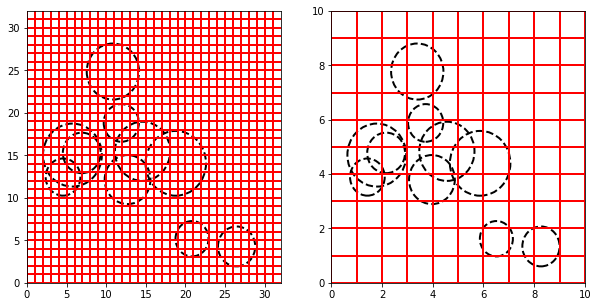

In [24]:
data = np.ones((1024,32,32))
n_fibers = 10
size_y = data.shape[1]
size_x = data.shape[2]
max_fiber_diameter = 8
core_diameter_pixels = np.random.uniform(low=4,high=max_fiber_diameter,size=n_fibers)
core_x_pixels = np.random.uniform(low=max_fiber_diameter/2,high=size_x-max_fiber_diameter/2,size=n_fibers)
core_y_pixels = np.random.uniform(low=max_fiber_diameter/2,high=size_x-max_fiber_diameter/2,size=n_fibers)
output_grid_dims = (10,10)

def Fiber_Observe(cube_data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=False):
    '''
    Produces an ndarray of losvds/spectra for each fiber applied to the data. 
    
    `cube_data` [numpy.ndarray] must be in format (`Nels`,`spatial_yels`,
    `spatial_xels`). `Nels` denotes the number of wavelength/velocity elements.
    `spatial_xels` and `spatial_yels` denote the spatial dimensions of the data.
    Consequently, `cube_data[0]` should return a slice of the cube with dimensions: 
    
    `cube_data[0].shape`: (`spatial_yels`,`spatial_xels`). 
    
    `core_x[y]_pixels`: [float,int,list,numpy.ndarray] 
        The `x`[`y`] (or column[row]) positions of the fiber core centroids. Can 
        be a single value (e.g. float) or an array/list of values for multiple 
        fibers. Must have a number of elements which matches `core_y_pixels`. 
        Used to determine the number of fibers to be applied. Values should be 
        in pixels (not, for example, arcsec).
    
    `core_diameter_pixels`: [float,int,list,numpy.ndarray]
        The diameter of each fiber core in pixels. The number of elements must 
        either match `core_x[y]_pixels` OR be a single value for all fibers. 
        In the latter scenario, it is assumed that all cores have the same
        diameter.
    
    Returns:
    
        ndarray with shape (`N_fibers`, `Nels`) where each row 
    is the spectra/losvd "observed" by the fiber in the data. The algorithm first 
    selects a rectangular set of pixels around the fiber in the data. These pixels
    are then further refined spatially by a factor which guarantees that there are 
    at least 100 spatial elements along the diameter of the fiber. The number of 
    sub-pixels within each proper pixel within the fiber is then computed to 
    estimate the area of each pixel subtended by the fiber. The resulting weight 
    map is applied to the data at each spectral/losvd slice to produce a single 
    fiber array.
    
    if return_weights (default False):
    
        ndarray with shape (N_fibers,spatial_y,spatial_x) which contains weight maps
    for the contribution of each fiber to each pixel in the input grid.
    '''
    
    data_shape = cube_data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    # Each refined grid is unique to the scale factor.
    # Each original grid can also differ. Therefore, need loop.
    for i in np.arange(N_fibers):
        
        col_max_ = col_max[i]
        col_min_ = col_min[i]
        row_max_ = row_max[i]
        row_min_ = row_min[i]
        rfactor_ = rfactor[i]
        core_x_pixels_ = core_x_pixels[i]
        core_y_pixels_ = core_y_pixels[i]
        core_radius_pixels_ = core_radius_pixels[i]
        
        rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
        Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
        maskr = np.zeros((rsize_y,rsize_x))

        maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                      (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1

        weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
        weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
        patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
        weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch
        
    cube_data = cube_data[np.newaxis,...]    
    core_array = np.sum(cube_data*weight_map.reshape(N_fibers,1,size_y,size_x),axis=(2,3))
    return (core_array,weight_map) if return_weights else core_array




def Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                  input_grid_dims,output_grid_dims):
    
    '''
    This tool is used to map the fiber core centroid locations on the image plane to a new
    grid covering the same field of view (FOV) but with an arbitrary pixel scale. This pixel
    scale is set by the ratio of `input_grid_dims` to `output_grid_dims`. Consequently, the 
    coordinates of objects in an input grid with dimensions (10,10) could be mapped to (3,3)
    with a scale of 0.333.
    
    Output FOV is always the same as the input FOV! The scale is the only thing that differs.
    The scale must be equal in both x- and y- dimensions. Consequently, an initial grid of 
    (10,15) cannot be scaled to (5,3) as this would require a scale of 2 in the y-direction 
    and a scale of 5 in the x-direction. 
    
    Argument descriptions are the same as for the Fiber_Observe function.
    
    `input_grid_dims` [int,tuple]: 
    The dimensions of the input grid in which the coordinates of the fiber cores are set.
    
     `output_grid_dims` [int,tuple]: 
    The dimensions of the output grid into which the coordinates of the fiber cores are to 
    be determined.
    
    Returns:
    
    
    '''
    
    if type(input_grid_dims)==tuple and type(output_grid_dims)==tuple:
        try:
            osize_y,osize_x = output_grid_dims[0],output_grid_dims[1]
            size_y,size_x = input_grid_dims[0],input_grid_dims[1]
        except:
            raise Exception('Grid dimensions are tuples but do not contain two elements. Stopping...')
    elif type(input_grid_dims)==int and type(output_grid_dims)==int:
        osize_y,osize_x = output_grid_dims,output_grid_dims
        size_y,size_x = input_grid_dims,input_grid_dims
    else:
        raise Exception('Grid dimensions must either be both tuples, e.g. (nrows,ncols), or both ints. Stopping...')
        
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to `core_x_pixels` and `core_y_pixels`. Stopping...")
    
    scale = float(osize_y)/size_y
    scale_x = float(osize_x)/size_x
    if scale_x != scale:
        raise Exception("The scale by which the input coordinates are converted to output coordinates must be the same in x- and y- dimensions. Make sure that `input_grid_dims` and `output_grid_dims` satisfy this condition. Stopping...")
    
    core_x_pixels *= scale
    core_y_pixels *= scale
    core_diameter_pixels *= scale
    print(size_x,size_y,osize_x,osize_y,scale)
    
    return core_x_pixels.flatten(),core_y_pixels.flatten(),core_diameter_pixels.flatten()
    
    
    
    
def Fiber_to_Grid(fiber_data,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels,
                  use_gaussian_weights=False,gaussian_sigma_pixels=1.4):
    
    fiber_data = np.array(fiber_data,dtype=float)
    data_shape = fiber_data.shape
    if len(data_shape) == 1:
        N_fibers,Nels = 1,data_shape[0]
        fiber_data = fiber_data.reshape(1,Nels)
    elif len(data_shape) == 2:
        N_fibers,Nels = data_shape[0],data_shape[1]
    else:
        raise Exception("fiber_data can have either one or two axes. No more, no less. Stopping...")
    
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)

    if type(grid_dimensions_pixels) == int:
        size_y,size_x = grid_dimensions_pixels,grid_dimensions_pixels
    elif type(grid_dimensions_pixels) == tuple:
        size_y,size_x = grid_dimensions_pixels 
    else:
        raise Exception("grid_dimensions_pixels must be an int or a tuple of two ints (e.g. '(10,10)')")
        
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1    
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    if not use_gaussian_weights:
        
        # Each refined patch is unique to the scale factor.
        # Each original patch can also differ. Therefore, need loop.
        for i in np.arange(N_fibers):

            col_max_ = col_max[i]
            col_min_ = col_min[i]
            row_max_ = row_max[i]
            row_min_ = row_min[i]
            rfactor_ = rfactor[i]
            core_x_pixels_ = core_x_pixels[i]
            core_y_pixels_ = core_y_pixels[i]
            core_radius_pixels_ = core_radius_pixels[i]

            rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
            Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
            maskr = np.zeros((rsize_y,rsize_x))

            maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                          (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1
            
            weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
            weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
            patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
            weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch/np.sum(patch)
            weight_map[np.isnan(weight_map)]==0.

        out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        return out_cube,weight_map

start = time.time()
# core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=True)

out = Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,input_grid_dims=(size_y,size_x),output_grid_dims=output_grid_dims)

# out,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels=output_grid_dims)
print(time.time()-start)

fig,axarr = plt.subplots(1,2,figsize=(10,5))

ax = axarr[0]
for core_x,core_y,core_diam in zip(core_x_pixels,core_y_pixels,core_diameter_pixels):

    #ax.imshow(wgt,cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)
    for i in range(size_x):
        ax.axvline(i,color='red')
        ax.axhline(i,color='red')

    core = Circle(xy=(core_x,core_y),radius=core_diam/2,
                  transform=ax.transData,edgecolor='black',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
ax.set_xlim(0,size_x)
ax.set_ylim(0,size_y)

ax = axarr[1]

for core_x,core_y,core_diam in zip(out[0],out[1],out[2]):

    #ax.imshow(wgt,cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)
    for i in range(size_x):
        ax.axvline(i,color='red')
        ax.axhline(i,color='red')

    core = Circle(xy=(core_x,core_y),radius=core_diam/2,
                  transform=ax.transData,edgecolor='black',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)
ax.set_xlim(0,output_grid_dims[1])
ax.set_ylim(0,output_grid_dims[0])

# fig,ax = plt.subplots(figsize=(5,5))

# ax.imshow(out[0],cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0)

# for i in range(size_x):
#     ax.axvline(i,color='red')
#     ax.axhline(i,color='red')


[[7.9511157  7.9511157  7.9511157  7.9511157  7.9511157  7.91235649
  7.83669434 7.66936687 7.44355242 7.28632123 7.23033242 7.22711616
  7.27071542 7.32080799 7.36255599 7.38900456]
 [7.9511157  7.9511157  7.9511157  7.9511157  7.9511157  7.91653174
  7.84788721 7.69053312 7.46518472 7.29860691 7.23830328 7.23585213
  7.28211818 7.33152678 7.36994544 7.39309663]
 [7.9511157  7.9511157  7.9511157  7.9511157  7.9511157  7.92027591
  7.85813781 7.71087381 7.48745608 7.31178062 7.24706967 7.24538227
  7.29370253 7.34161925 7.3765031  7.39660046]
 [7.9511157  7.9511157  7.9511157  7.9511157  7.9511157  7.92362963
  7.86749604 7.7302999  7.51022977 7.32580586 7.25662513 7.25562728
  7.30526354 7.35097547 7.38226398 7.39958439]
 [7.9511157  7.9511157  7.9511157  7.9511157  7.9511157  7.9511157
  7.8760151  7.74874261 7.53335555 7.34061918 7.2669353  7.26646841
  7.31659792 7.35952501 7.38728005 7.40211384]
 [0.         7.9511157  7.9511157  7.9511157  7.9511157  7.9511157
  7.88375005 7.7661

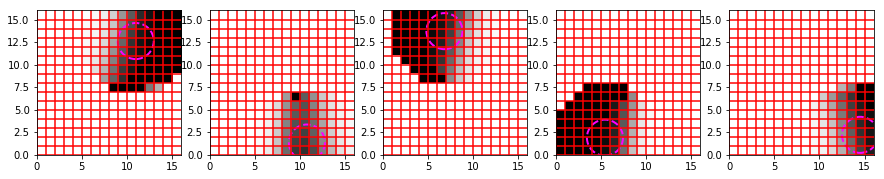

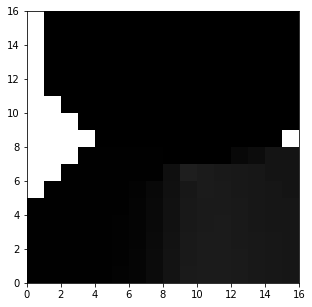

In [208]:
data = np.ones((1024,32,32))*2
#data[:,:,16:] = 2
n_fibers = 5
size_y = data.shape[1]
size_x = data.shape[2]
max_fiber_diameter = 4
#np.random.seed(1213)
core_diameter_pixels = np.ones(n_fibers)*8 #np.random.uniform(low=1,high=max_fiber_diameter,size=n_fibers)
core_x_pixels = np.random.uniform(low=max_fiber_diameter/2.,high=size_x-max_fiber_diameter/2.,size=n_fibers)
core_y_pixels = np.random.uniform(low=max_fiber_diameter/2.,high=size_x-max_fiber_diameter/2.,size=n_fibers)
output_grid_dims = (16,16)

def Fiber_Observe(cube_data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=False):
    '''
    Produces an ndarray of losvds/spectra for each fiber applied to the data. 
    
    `cube_data` [numpy.ndarray] must be in format (`Nels`,`spatial_yels`,
    `spatial_xels`). `Nels` denotes the number of wavelength/velocity elements.
    `spatial_xels` and `spatial_yels` denote the spatial dimensions of the data.
    Consequently, `cube_data[0]` should return a slice of the cube with dimensions: 
    
    `cube_data[0].shape`: (`spatial_yels`,`spatial_xels`). 
    
    `core_x[y]_pixels`: [float,int,list,numpy.ndarray] 
        The `x`[`y`] (or column[row]) positions of the fiber core centroids. Can 
        be a single value (e.g. float) or an array/list of values for multiple 
        fibers. Must have a number of elements which matches `core_y_pixels`. 
        Used to determine the number of fibers to be applied. Values should be 
        in pixels (not, for example, arcsec).
    
    `core_diameter_pixels`: [float,int,list,numpy.ndarray]
        The diameter of each fiber core in pixels. The number of elements must 
        either match `core_x[y]_pixels` OR be a single value for all fibers. 
        In the latter scenario, it is assumed that all cores have the same
        diameter.
    
    Returns:
    
        ndarray with shape (`N_fibers`, `Nels`) where each row 
    is the spectra/losvd "observed" by the fiber in the data. The algorithm first 
    selects a rectangular set of pixels around the fiber in the data. These pixels
    are then further refined spatially by a factor which guarantees that there are 
    at least 100 spatial elements along the diameter of the fiber. The number of 
    sub-pixels within each proper pixel within the fiber is then computed to 
    estimate the area of each pixel subtended by the fiber. The resulting weight 
    map is applied to the data at each spectral/losvd slice to produce a single 
    fiber array.
    
    if return_weights (default False):
    
        ndarray with shape (N_fibers,spatial_y,spatial_x) which contains weight maps
    for the contribution of each fiber to each pixel in the input grid.
    '''
    
    data_shape = cube_data.shape
    if len(data_shape) != 3:
        raise Exception("Data must have three axes with dimensions (Nels,spatial_y,spatial_x). Stopping...")
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    # initialize weight map
    weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

    # select rectangular region around fiber to refine for weight estimates
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    indices = np.argwhere(weight_map)
    slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]
    
    row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
    row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
    col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
    col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]
    
    # the refined grid is defined to have a minimum of 100 pixels
    # across the diameter of the fiber
    rfactor = (100/core_diameter_pixels).astype(int)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    rfactor[rfactor<1]=1
    
    # handling condition where a single core diameter is given
    if len(rfactor)==1 and N_fibers>1:
        core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
        rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
    weight_map = weight_map.astype(float)

    # Each refined grid is unique to the scale factor.
    # Each original grid can also differ. Therefore, need loop.
    for i in np.arange(N_fibers):
        
        col_max_ = col_max[i]
        col_min_ = col_min[i]
        row_max_ = row_max[i]
        row_min_ = row_min[i]
        rfactor_ = rfactor[i]
        core_x_pixels_ = core_x_pixels[i]
        core_y_pixels_ = core_y_pixels[i]
        core_radius_pixels_ = core_radius_pixels[i]
        
        rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
        Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
        maskr = np.zeros((rsize_y,rsize_x))

        maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                      (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1

        weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
        weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
        patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
        weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch
        
    cube_data = cube_data[np.newaxis,...]    
    core_array = np.sum(cube_data*weight_map.reshape(N_fibers,1,size_y,size_x),axis=(2,3))
    return (core_array,weight_map) if return_weights else core_array


def Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                  input_grid_dims,output_grid_dims):
    
    '''
    This tool is used to map the fiber core centroid locations on the image plane to a new
    grid covering the same field of view (FOV) but with an arbitrary pixel scale. This pixel
    scale is set by the ratio of `input_grid_dims` to `output_grid_dims`. Consequently, the 
    coordinates of objects in an input grid with dimensions (10,10) could be mapped to (3,3)
    with a scale of 0.333.
    
    Output FOV is always the same as the input FOV! The scale is the only thing that differs.
    The scale must be equal in both x- and y- dimensions. Consequently, an initial grid of 
    (10,15) cannot be scaled to (5,3) as this would require a scale of 2 in the y-direction 
    and a scale of 5 in the x-direction. 
    
    The tool also uses the scale to correct for the ratio of intensities that are received by
    an individual pixel in the original grid and that should be received by a new pixel in 
    the output grid. For example, if the original grid has shape (10,10) and the output has
    shape (5,5), the intensity in `core_array` must decrease by a factor of 4 for the new grid
    because every 4 pixels in the original grid are covering the area of 1 pixel in the new 
    grid. This factor must be applied ONLY because there is no normalization of the intensity
    registered by the fibers in `Fiber_Observe`.
    
    Argument descriptions are the same as for the Fiber_Observe function.
    
    `input_grid_dims` [int,tuple]: 
    The dimensions of the input grid in which the coordinates of the fiber cores are set.
    
     `output_grid_dims` [int,tuple]: 
    The dimensions of the output grid into which the coordinates of the fiber cores are to 
    be determined.
    
    Returns:
    
    `core_x_pixels`,`core_y_pixels`,`core_diameter_pixels` scaled to the new grid dimensions.
    
    
    '''
    
    if type(input_grid_dims)==tuple and type(output_grid_dims)==tuple:
        try:
            osize_y,osize_x = output_grid_dims[0],output_grid_dims[1]
            size_y,size_x = input_grid_dims[0],input_grid_dims[1]
        except:
            raise Exception('Grid dimensions are tuples but do not contain two elements. Stopping...')
    elif type(input_grid_dims)==int and type(output_grid_dims)==int:
        osize_y,osize_x = output_grid_dims,output_grid_dims
        size_y,size_x = input_grid_dims,input_grid_dims
    else:
        raise Exception('Grid dimensions must either be both tuples, e.g. (nrows,ncols), or both ints. Stopping...')
        
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    N_fibers = core_x_pixels.shape[0]
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to `core_x_pixels` and `core_y_pixels`. Stopping...")
    
    scale = float(osize_y)/size_y
    scale_x = float(osize_x)/size_x
    if scale_x != scale:
        raise Exception("The scale by which the input coordinates are converted to output coordinates must be the same in x- and y- dimensions. Make sure that `input_grid_dims` and `output_grid_dims` satisfy this condition. Stopping...")
    
    core_x_pixels *= scale
    core_y_pixels *= scale
    core_diameter_pixels *= scale
    #print(size_x,size_y,osize_x,osize_y,scale)
    
    return core_x_pixels.flatten(),core_y_pixels.flatten(),core_diameter_pixels.flatten()
    
    
    
    
def Fiber_to_Grid(fiber_data,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels,
                  use_gaussian_weights=False,gaussian_sigma_pixels=1.4,rlim_pixels=None):
    
    '''
    With a fiber core array [ndarray] with shape (`N_fibers`,`Nels`) along with their
    x- and y- coordinates (centroid) on a grid of dimensions `grid_dimensions_pixels`,
    this tool computes the intensity contribution of each fiber to each pixel of the grid.
    There are two options:
    
    (1) The intensity is distributed uniformly over all pixels completely contained within
    the fiber and partially within pixels that partially overlap with the fiber. In
    this respect, the method is exactly analogous to Fiber_Observe but in reverse. 
    Pixels that partially overlap with the fiber receive a portion of the intensity that
    is weighted by fraction of area of overlap with respect to a full pixel size. This
    method conserves intensity. This is checked by taking the sum along axis=0 of 
    `fiber_data` (the fiber axis) and comparing to the sum in each wavelength/losvd 
    slice (axis=(1,2)) of the output datacube. The output cube will therefore have a
    total sum that is equal to the sum of fiber_data, but distributed on the grid. 
    
    (2) The weights are determined by adopting a gaussian distribution of the intensity from
    each fiber on the output grid. This method emulates the SDSS-IV MaNGA data reduction
    pipeline. Specifically, see LAW et al. 2016 (AJ,152,83), Section 9.1 on the 
    construction of the regularly sampled cubes from the non-regularly sampled fiber
    data. The intensity contribution from each fiber, f[i], to each regularly spaced output
    pixel is mapped by a gaussian distribution:
    
    w[i,j] = exp( -0.5 * r[i,j]^2 / sigma^2 )
    
    where r[i,j] is the distance between the fiber core and the pixel centroid and 
    sigma is a constant of decay (taken to by 0.7 arcsec for MaNGA, for example). 
    These weights are necessarily normalized to conserve intensity. 
    
    W[i,j] = w[i,j] / SUM(w[i,j]) from k=1 to N_fibers 
    
    Where the sum is over all fibers. Note that there is a distinction between the 
    N_fibers used in LAW et al. 2016 and the one used here. Here, N_fibers refers
    to all fibers from all exposures (equivalent to the N used by LAW et al. 2016). 
    Additionally, the `alpha` parameter used in LAW et al. 2016 is computed and applied
    to the intensities. `alpha` converts the "per fiber" intensity to the "per pixel"
    intensity in the new grid. #Since all units are in pixels and the 
    
    
    '''
    
    fiber_data = np.array(fiber_data,dtype=float)
    data_shape = fiber_data.shape
    if len(data_shape) == 1:
        N_fibers,Nels = 1,data_shape[0]
        fiber_data = fiber_data.reshape(1,Nels)
    elif len(data_shape) == 2:
        N_fibers,Nels = data_shape[0],data_shape[1]
    else:
        raise Exception("fiber_data can have either one or two axes. No more, no less. Stopping...")
    
    if type(core_x_pixels) in [float,int]: 
        core_x_pixels = np.array([core_x_pixels,]).astype(float)
    elif type(core_x_pixels) in [list,np.ndarray]:
        core_x_pixels = np.array(core_x_pixels).astype(float)
    else:
        try: 
            core_x_pixels = np.array([float(core_x_pixels),])
        except:
            raise Exception("core_x_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_y_pixels) in [float,int]:
        core_y_pixels = np.array([core_y_pixels,]).astype(float)
    elif type(core_y_pixels) in [list,np.ndarray]:
        core_y_pixels = np.array(core_y_pixels).astype(float)
    else:
        try: 
            core_y_pixels = np.array([float(core_y_pixels),])
        except:
            raise Exception("core_y_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    if type(core_diameter_pixels) in [float,int]:
        core_diameter_pixels = np.array([core_diameter_pixels,]).astype(float)
    elif type(core_diameter_pixels) in [list,np.ndarray]:
        core_diameter_pixels = np.array(core_diameter_pixels).astype(float)
    else:
        try: 
            core_diameter_pixels = np.array([float(core_diameter_pixels),])
        except:
            raise Exception("core_diameter_pixels not in accepted format. Use a list, numpy array, int, or float. Stopping...")
        
    # check that x,y core position array dimensions match
    if core_x_pixels.shape != core_y_pixels.shape:
        raise Exception("Fiber core x- and y- position arrays (or lists/values) do not have matching dimensions. Stopping...")
    
    # core radius not necessarily constant but may be particular to each fiber
    if core_diameter_pixels.shape[0] not in [1,N_fibers]:
        raise Exception("Fiber core_diameter_pixels must either be a single float (all/any fibers have the same diameter) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")
    core_radius_pixels = core_diameter_pixels/2
    core_radius_pixels = core_radius_pixels.reshape(-1,1,1)
    core_x_pixels = core_x_pixels.reshape(-1,1,1)
    core_y_pixels = core_y_pixels.reshape(-1,1,1)

    if type(grid_dimensions_pixels) == int:
        size_y,size_x = grid_dimensions_pixels,grid_dimensions_pixels
    elif type(grid_dimensions_pixels) == tuple:
        size_y,size_x = grid_dimensions_pixels 
    else:
        raise Exception("grid_dimensions_pixels must be an int or a tuple of two ints (e.g. '(10,10)')")
        
    Y,X = np.ogrid[0:size_y,0:size_x]
    Y = Y[np.newaxis,...]
    X = X[np.newaxis,...]
    
    if not use_gaussian_weights:
        
        # initialize weight map
        weight_map = np.zeros((N_fibers,size_y,size_x)).astype(int)

        # select rectangular region around fiber to refine for weight estimates
        weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
                   (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1

        indices = np.argwhere(weight_map)
        slices,rows,cols = indices[:,0],indices[:,1],indices[:,2]

        row_min = [np.min(rows[slices==i]) for i in range(N_fibers)]
        row_max = [np.max(rows[slices==i])+1 for i in range(N_fibers)]
        col_min = [np.min(cols[slices==i]) for i in range(N_fibers)]
        col_max = [np.max(cols[slices==i])+1 for i in range(N_fibers)]

        # the refined grid is defined to have a minimum of 100 pixels
        # across the diameter of the fiber
        rfactor = (100/core_diameter_pixels).astype(int)
        # if the diameter exceeds 100 pixels already, 
        # use the original regular grid
        rfactor[rfactor<1]=1    

        # handling condition where a single core diameter is given
        if len(rfactor)==1 and N_fibers>1:
            core_radius_pixels = np.ones((N_fibers),dtype=int).flatten()*core_radius_pixels.flatten()
            rfactor = np.ones((N_fibers),dtype=int)*rfactor.flatten()
        weight_map = weight_map.astype(float)
        
        # Each refined patch is unique to the scale factor.
        # Each original patch can also differ. Therefore, need loop.
        for i in np.arange(N_fibers):

            col_max_ = col_max[i]
            col_min_ = col_min[i]
            row_max_ = row_max[i]
            row_min_ = row_min[i]
            rfactor_ = rfactor[i]
            core_x_pixels_ = core_x_pixels[i]
            core_y_pixels_ = core_y_pixels[i]
            core_radius_pixels_ = core_radius_pixels[i]

            rsize_x,rsize_y = (col_max_-col_min_)*rfactor_,(row_max_-row_min_)*rfactor_
            Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
            maskr = np.zeros((rsize_y,rsize_x))

            maskr[np.sqrt((Xr+col_min_*rfactor_+0.5 - core_x_pixels_*rfactor_)**2 +
                          (Yr+row_min_*rfactor_+0.5 - core_y_pixels_*rfactor_)**2) < core_radius_pixels_*rfactor_ ]=1
            
            weight_mapr = np.zeros((size_y*rfactor_,size_x*rfactor_))
            weight_mapr[row_min_*rfactor_:row_max_*rfactor_,col_min_*rfactor_:col_max_*rfactor_] = maskr
            patch = maskr.reshape(row_max_-row_min_,rfactor_,col_max_-col_min_,rfactor_).sum(axis=(1,3)).astype(float)/rfactor_**2
            weight_map[i,row_min_:row_max_,col_min_:col_max_]=patch/np.sum(patch)
            weight_map[np.isnan(weight_map)]=0.

        out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        return out_cube,weight_map
    
    else:
        
        # check `gaussian_sigma_pixels` type
        if type(gaussian_sigma_pixels) in [float,int]:
            gaussian_sigma_pixels = np.array([gaussian_sigma_pixels,]).astype(float)
        elif type(gaussian_sigma_pixels) in [list,np.ndarray]:
            gaussian_sigma_pixels = np.array(gaussian_sigma_pixels).astype(float)
        else:
            try: 
                gaussian_sigma_pixels = np.array([float(gaussian_sigma_pixels),])
            except:
                raise Exception("`gaussian_sigma_pixels` not in accepted format. Use a list, numpy array, int, or float. Stopping...")

        # gaussian_sigma_pixels not necessarily constant but may be particular to each fiber
        if gaussian_sigma_pixels.shape[0] not in [1,N_fibers]:
            raise Exception("`gaussian_sigma_pixels` must either be a single float (all/any fibers have the same sigma) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")

        # handling condition where a gaussian_sigma_pixels is given
        if len(gaussian_sigma_pixels)==1 and N_fibers>1:
            gaussian_sigma_pixels = np.ones((N_fibers),dtype=int).flatten()*gaussian_sigma_pixels.flatten()
        
        # generate cube of 2d gaussian pdfs with output grid dimensions
        r2 = ((X+0.5)-core_x_pixels)**2 + ((Y+0.5)-core_y_pixels)**2
        weight_map = np.exp(-r2/gaussian_sigma_pixels.reshape(N_fibers,1,1)**2)
        
        # for each fiber, all pixel weights outside `rlim_pixels` are zero
        if rlim_pixels is not None:
            
            if type(rlim_pixels) in [float,int]:
                rlim_pixels = np.array([rlim_pixels,]).astype(float)
            elif type(rlim_pixels) in [list,np.ndarray]:
                rlim_pixels = np.array(rlim_pixels).astype(float)
            else:
                try: 
                    rlim_pixels = np.array([float(rlim_pixels),])
                except:
                    raise Exception("`rlim_pixels` not in accepted format. Use a list, numpy array, int, or float. Stopping...")

            # gaussian_sigma_pixels not necessarily constant but may be particular to each fiber
            if rlim_pixels.shape[0] not in [1,N_fibers]:
                raise Exception("`rlim_pixels` must either be a single float (all/any fibers have the same sigma) or an array/list of length equal to core_x_pixels and core_y_pixels. Stopping...")

            # handling condition where a gaussian_sigma_pixels is given
            if len(rlim_pixels)==1 and N_fibers>1:
                rlim_pixels = np.ones((N_fibers),dtype=int).flatten()*rlim_pixels.flatten()
        
            weight_map[np.sqrt(r2)>rlim_pixels.reshape(N_fibers,1,1)] = 0
        
        # normalization to determine intensity contribution of each fiber to each pixel
        # as in LAW et al 2016
        alpha = 1./(np.pi*(core_diameter_pixels/2.)**2)
        normalization = np.sum(weight_map,axis=0)
        normalization[normalization==0]=np.nan
        weight_map/=normalization

        weight_map*=alpha.reshape(N_fibers,1,1)
        weight_map[np.isnan(weight_map)]=0
        out_cube = np.sum(fiber_data.reshape(N_fibers,Nels,1,1)*weight_map.reshape(N_fibers,1,size_y,size_x),axis=0)
        return out_cube,weight_map
    

core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,
                                       return_weights=True)

core_x_pixels,core_y_pixels,core_diameter_pixels = Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,
                                                                 input_grid_dims=(size_y,size_x),
                                                                 output_grid_dims=output_grid_dims)

out_cube,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,
                    grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                    gaussian_sigma_pixels=3.,rlim_pixels=6.)

fig,axarr = plt.subplots(1,5,figsize=(15,3))

for i in np.arange(weight_map.shape[0]):
    ax = axarr[i]
    ax.imshow(weight_map[i],extent=(0,output_grid_dims[1],0,output_grid_dims[0]),cmap = 'Greys',origin='lower',vmin=0,)
    for j in range(output_grid_dims[1]):
        ax.axvline(j,color='red')
        ax.axhline(j,color='red')
    core = Circle(xy=(core_x_pixels[i],core_y_pixels[i]),radius=core_diameter_pixels[i]/2,
                  transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
    ax.add_artist(core)

fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(out_cube[0],extent=(0,output_grid_dims[1],0,output_grid_dims[0]),cmap = 'Greys',origin='lower',vmin=0)


# fig,axarr = plt.subplots(2,5,figsize=(15,6))
# core_arrays,weight_map = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels,return_weights=True)

# for ax,wgt,core_x,core_y,core_diam in zip(axarr.flat[:5],weight_map,core_x_pixels,core_y_pixels,core_diameter_pixels):
# #     print(np.sum(wgt))
# #     print(core_arrays)
#     ax.imshow(wgt,cmap='Greys',extent=(0,size_x,0,size_y),origin='lower',vmin=0,vmax=1)
#     for i in range(size_x):
#         ax.axvline(i,color='red')
#         ax.axhline(i,color='red')

#     core = Circle(xy=(core_x,core_y),radius=core_diam/2,
#                   transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
#     ax.add_artist(core)

# print(np.sum(core_arrays[:,0]))
# core_x_pixels,core_y_pixels,core_diameter_pixels = Change_Coords(core_x_pixels,core_y_pixels,core_diameter_pixels,input_grid_dims=(size_y,size_x),output_grid_dims=output_grid_dims)



# out_cube,weight_map = Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,grid_dimensions_pixels=output_grid_dims)


# # norm = np.sum(weight_map,axis=0)
# # norm[norm==0.] = np.nan
# # out_cube = out_cube/norm
# # out_cube[np.isnan(out_cube)]=0.

# osize_y,osize_x = output_grid_dims

# #print(weight_map)
# for ax,wgt,core_x,core_y,core_diam in zip(axarr.flat[5:10],weight_map,core_x_pixels,core_y_pixels,core_diameter_pixels):
# #     print(np.sum(wgt))
# #     print(core_arrays)
#     ax.imshow(wgt,cmap='Greys',extent=(0,osize_x,0,osize_y),origin='lower',vmin=0,vmax=1)
#     for i in range(osize_x):
#         ax.axvline(i,color='red')
#         ax.axhline(i,color='red')

#     core = Circle(xy=(core_x,core_y),radius=core_diam/2,
#                   transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')
#     ax.add_artist(core)

# fig,ax = plt.subplots(figsize=(5,5))
# print(np.sum(out_cube[0]))
# ax.imshow(out_cube[0],cmap='Greys',extent=(0,osize_x,0,osize_y),origin='lower',vmin=0)

# for i in range(osize_x):
#     ax.axvline(i,color='red')
#     ax.axhline(i,color='red')
print(out_cube[0])
print(np.sum(data,axis=(1,2)))
print(np.sum(out_cube,axis=(1,2)))


0.2454369260617026
2048
